In [3]:
import warnings
import os 
from pathlib import Path
import pandas as pd 
from logbook import Logger, StderrHandler, INFO, WARNING
import numpy as np 

from zipline import run_algorithm
from zipline.api import (attach_pipeline, pipeline_output,
                         date_rules, time_rules, record,
                         schedule_function, commission, slippage,
                         set_slippage, set_commission, set_max_leverage,
                         order_target, order_target_percent,
                         get_open_orders, cancel_order, set_benchmark, symbol,
                         set_long_only
                        )
from zipline.data import bundles
from zipline.utils.run_algo import load_extensions
from zipline.pipeline import Pipeline, CustomFactor
from zipline.pipeline.data import Column, DataSet
from zipline.pipeline.domain import KR_EQUITIES
from zipline.pipeline.filters import StaticAssets
from zipline.pipeline.factors import AverageDollarVolume, Returns
from zipline.pipeline.loaders import KREquityPricingLoader
from zipline.pipeline.loaders.frame import DataFrameLoader
from trading_calendars import get_calendar

import pyfolio as pf
from pyfolio.plotting import plot_rolling_returns, plot_rolling_sharpe
from pyfolio.timeseries import forecast_cone_bootstrap

In [4]:
warnings.filterwarnings('ignore')

## Load Zipline Extension

In [5]:
os.environ['ZIPLINE_ROOT'] = 'C:/Users/PC/.zipline/'

In [6]:
load_extensions(default=True,
                extensions=[],
                strict=True,
                environ=None)

In [7]:
log_handler = StderrHandler(format_string='[{record.time:%Y-%m-%d %H:%M:%S.%f}]: ' +
                            '{record.level_name}: {record.func_name}: {record.message}',
                            level=WARNING)
log_handler.push_application()
log = Logger('Algorithm')

## Algo Params

In [8]:
N_LONGS = 20
VOL_SCREEN = 650

## Load DataReader Bundles

In [9]:
bundle_data = bundles.load('fnguide')

In [10]:
idx = pd.IndexSlice

In [11]:
def load_factor(bundle):
    with pd.HDFStore('../factor.h5') as store: 
        factor = (store['value/psr']
                   .loc[idx['2000':'2021', :], :]
                  )
        factor = factor[factor['Ratio'] > 0]
    tickers = factor.index.get_level_values('ticker').unique().tolist()
    
    assets = []
    for ticker in tickers:
        try:
            asset = bundle.asset_finder.lookup_symbol(ticker, as_of_date=None)
            assets.append(asset)
        except Exception as e:
            print(e)
    factor_sids = pd.Int64Index([asset.sid for asset in assets])
    ticker_map = dict(zip(tickers, factor_sids))
    return (factor
            .unstack('ticker')
            .rename(columns=ticker_map)
            .Ratio
            .tz_localize('UTC')
            .fillna(method='ffill')
           ), assets

In [12]:
psr, assets = load_factor(bundle_data)

## Define Custom Dataset

In [14]:
class PSRData(DataSet):
    ratio = Column(dtype=float)
    domain = KR_EQUITIES

## Define Pipeline Loaders

In [15]:
psr_loader = {PSRData.ratio: DataFrameLoader(PSRData.ratio, psr)}

## Pipeline & Setup

In [17]:
class PSR(CustomFactor):
    inputs = [PSRData.ratio]
    window_length = 1
    
    def compute(self, today, assets, out, psr):
        out[:] = psr

## Create Pipeline

In [18]:
def compute_factors():
    psr = PSR()
    dollar_volume = AverageDollarVolume(window_length=30)
    return Pipeline(columns={
        'longs': psr.bottom(N_LONGS),
        'ranking': psr.rank(ascending=False),
        },
        screen=dollar_volume.top(600)
    )

## Initialize Algorithm

In [19]:
def exec_trades(data, assets, target_percent):
    for asset in assets:
        if data.can_trade(asset) and not get_open_orders(asset):
            order_target_percent(asset, target_percent)

In [20]:
def rebalance(context, data):
    print(context.datetime)
    factor_data = pipeline_output('factor_pipeline')
    record(factor_data=factor_data.ranking)

    assets = factor_data.index
    record(prices=data.current(assets, 'price'))

    longs = assets[factor_data.longs]
    divest = set(context.portfolio.positions.keys()) - set(longs)

    # 보유 주식 처분
    exec_trades(data, assets=divest, target_percent=0)
    # 새롭게 리밸런싱
    exec_trades(data, assets=longs, target_percent=1 / N_LONGS)

In [21]:
def initialize(context):
    """
    Called once at the start of the algorithm.
    """
    context.universe = assets
    context.longs = 0
    set_long_only()
    set_benchmark(symbol('kospi'))
    set_slippage(slippage.FixedSlippage(spread=0.01))
    set_commission(commission.PerShare(cost=0.002, min_trade_cost=0))

    attach_pipeline(pipeline=compute_factors(), name='factor_pipeline')
    schedule_function(rebalance,
                      date_rules.month_end(),
                      time_rules.market_close())       

In [22]:
start = pd.Timestamp('2000-01-01', tz='utc')
end = pd.Timestamp('2021-07-01', tz='utc')

## Start BackTest

In [23]:
results = run_algorithm(start=start,
                        end=end,
                        initialize=initialize,
                        capital_base=1e6,
                        data_frequency='daily',
                        bundle='fnguide',
                        trading_calendar=get_calendar('XKRX'),
                        custom_loader=psr_loader
                       )

2000-01-31 06:30:00+00:00
2000-02-29 06:30:00+00:00
2000-03-31 06:30:00+00:00
2000-04-28 06:30:00+00:00
2000-05-31 06:30:00+00:00
2000-06-30 06:30:00+00:00
2000-07-31 06:30:00+00:00
2000-08-31 06:30:00+00:00
2000-09-29 06:30:00+00:00
2000-10-31 06:30:00+00:00
2000-11-30 06:30:00+00:00
2000-12-26 06:30:00+00:00
2001-01-31 06:30:00+00:00
2001-02-28 06:30:00+00:00
2001-03-30 06:30:00+00:00
2001-04-30 06:30:00+00:00
2001-05-31 06:30:00+00:00
2001-06-29 06:30:00+00:00
2001-07-31 06:30:00+00:00
2001-08-31 06:30:00+00:00
2001-09-28 06:30:00+00:00
2001-10-31 06:30:00+00:00
2001-11-30 06:30:00+00:00
2001-12-28 06:30:00+00:00
2002-01-31 06:30:00+00:00
2002-02-28 06:30:00+00:00
2002-03-29 06:30:00+00:00
2002-04-30 06:30:00+00:00
2002-05-31 06:30:00+00:00
2002-06-28 06:30:00+00:00
2002-07-31 06:30:00+00:00
2002-08-30 06:30:00+00:00
2002-09-30 06:30:00+00:00
2002-10-31 06:30:00+00:00
2002-11-29 06:30:00+00:00
2002-12-30 06:30:00+00:00
2003-01-30 06:30:00+00:00
2003-02-28 06:30:00+00:00
2003-03-31 0

## PyFolio Analysis

In [24]:
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(results)

In [25]:
benchmark_period_returns = results['benchmark_period_return']
benchmark = np.exp(np.log(benchmark_period_returns + 1.0).diff()) - 1.0

## Tear Sheets

Start date,2000-01-04
End date,2021-07-01
Total months,252
,Backtest
Annual return,14.818%
Cumulative returns,1737.462%
Annual volatility,22.606%
Sharpe ratio,0.72
Calmar ratio,0.26
Stability,0.86
Max drawdown,-55.994%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,55.99,2018-05-28,2020-03-23,2021-02-23,717
1,38.77,2007-07-25,2008-10-27,2009-02-11,406
2,38.29,2002-05-23,2003-03-17,2004-03-09,469
3,37.25,2001-06-19,2001-09-17,2002-03-14,193
4,32.31,2000-09-20,2000-12-22,2001-06-18,194


Stress Events,mean,min,max
Dotcom,0.39%,-6.03%,9.42%
Lehman,-0.17%,-3.58%,3.62%
9/11,-0.24%,-12.83%,8.73%
US downgrade/European Debt Crisis,-0.33%,-4.83%,3.07%
Fukushima,0.02%,-0.91%,1.28%
US Housing,0.00%,-2.51%,3.45%
EZB IR Event,-0.01%,-1.37%,1.37%
Aug07,-0.05%,-6.40%,4.31%
Mar08,-0.14%,-2.14%,1.83%
Sept08,-0.00%,-3.58%,3.62%


Top 10 long positions of all time,max
sid,
005560,25.44%
007480,17.48%
005960,16.90%
009360,16.08%
011150,15.71%
013200,15.41%
117930,14.99%
005010,13.79%
001250,13.71%


Top 10 short positions of all time,max
sid,


Top 10 positions of all time,max
sid,
005560,25.44%
007480,17.48%
005960,16.90%
009360,16.08%
011150,15.71%
013200,15.41%
117930,14.99%
005010,13.79%
001250,13.71%


Summary stats,All trades,Short trades,Long trades
Total number of round_trips,1679.00,6.00,1673.00
Percent profitable,0.57,0.00,0.58
Winning round_trips,963.00,0.00,963.00
Losing round_trips,716.00,6.00,710.00
Even round_trips,0.00,0.00,0.00


PnL stats,All trades,Short trades,Long trades
Total profit,$17375406.77,$-0.50,$17375407.27
Gross profit,$50172653.02,$0.00,$50172653.02
Gross loss,$-32797246.25,$-0.50,$-32797245.75
Profit factor,$1.53,$0.00,$1.53
Avg. trade net profit,$10348.66,$-0.08,$10385.78
Avg. winning trade,$52100.37,NaN,$52100.37
Avg. losing trade,$-45806.21,$-0.08,$-46193.30
Ratio Avg. Win:Avg. Loss,$1.14,NaN,$1.13
Largest winning trade,$845699.63,$-0.01,$845699.63
Largest losing trade,$-651826.93,$-0.32,$-651826.93


Duration stats,All trades,Short trades,Long trades
Avg duration,125 days 06:58:04.217986896,0 days 06:29:59,125 days 17:43:43.077106994
Median duration,88 days 00:00:00,0 days 06:29:59,89 days 00:00:00
Longest duration,2482 days 00:00:00,0 days 06:29:59,2482 days 00:00:00
Shortest duration,0 days 06:29:59,0 days 06:29:59,1 days 00:00:00


Return stats,All trades,Short trades,Long trades
Avg returns all round_trips,0.14%,-0.04%,0.14%
Avg returns winning,0.77%,0.53%,0.77%
Avg returns losing,-0.70%,-2.86%,-0.69%
Median returns all round_trips,0.02%,0.25%,0.02%
Median returns winning,0.30%,0.35%,0.30%
Median returns losing,-0.28%,-2.86%,-0.27%
Largest winning trade,11.72%,1.51%,11.72%
Largest losing trade,-7.91%,-2.86%,-7.91%


Symbol stats,000040,000060,000080,000300,000360,000370,000400,000470,000500,000540,000610,000680,000700,001070,001120,001140,001230,001250,001380,001430,001450,001470,001520,001550,001580,001600,001620,001720,001740,001780,001790,001820,001880,001950,002020,002140,002300,002320,002360,002410,002450,002460,002530,002550,002700,002710,002780,002880,002900,002930,002990,003030,003070,003230,003280,003490,003530,003540,003620,003640,003660,003680,003690,003830,003900,003960,004010,004060,004100,004140,004200,004230,004530,004540,004550,004560,004690,004700,004740,004800,004820,004960,004980,005010,005030,005190,005320,005330,005350,005360,005390,005440,005450,005560,005600,005610,005760,005810,005830,005880,005950,005960,005980,006070,006090,006150,006200,006340,006380,006390,006750,006840,006980,007110,007190,007460,007480,007490,007630,007800,007860,008020,008040,008540,008560,008700,008900,008970,009180,009190,009200,009320,009360,009380,009460,009470,009690,009890,010100,010200,010420,010600,010690,010730,011050,011150,011160,011200,011230,011300,011330,011760,011810,012090,012280,012320,012410,012630,012720,012800,013200,013240,013360,013520,013580,013870,013890,014130,014350,014790,014900,015110,015360,015590,016380,016450,016560,016610,016710,016880,017040,017550,017940,018410,018470,018500,018670,019180,019490,020120,020560,021050,022520,023350,023800,023810,024100,024900,025820,025830,026940,027390,027740,027970,028050,028670,030610,030720,030790,031820,032710,036460,042660,044380,047050,058430,063350,063510,067250,071950,071970,073240,079660,082640,084010,085620,088350,090080,092220,097230,104110,104120,108670,109070,110570,117580,117930,122900,128820,129260,200880,213500,267290,298040,306200
Avg returns all round_trips,-0.11%,0.07%,-0.00%,0.25%,1.16%,0.31%,0.19%,0.12%,0.55%,0.42%,-1.00%,-0.22%,1.29%,-0.72%,0.55%,0.10%,0.04%,0.18%,-0.12%,-0.11%,0.53%,0.49%,0.11%,1.60%,0.06%,0.71%,-0.12%,0.10%,0.15%,-3.84%,0.22%,0.08%,0.57%,0.78%,1.00%,0.27%,4.57%,0.03%,0.95%,1.62%,1.79%,0.55%,0.03%,0.41%,0.13%,1.44%,0.08%,0.17%,-0.10%,0.06%,-0.28%,-0.59%,0.20%,-0.92%,0.52%,-0.45%,1.30%,-0.25%,-0.00%,-0.10%,0.35%,0.21%,0.08%,-0.08%,-0.26%,-0.90%,0.51%,-0.79%,-2.29%,1.18%,1.12%,1.88%,4.25%,0.37%,0.61%,-0.26%,-0.84%,0.02%,-0.01%,-0.07%,-0.10%,-0.20%,1.01%,-0.01%,0.31%,0.96%,0.03%,-0.41%,-0.89%,0.30%,-0.07%,0.44%,-0.05%,0.34%,0.08%,-0.18%,0.32%,-0.04%,1.64%,1.29%,0.32%,-0.78%,0.01%,-0.00%,-4.27%,-0.01%,0.01%,0.39%,-0.54%,-0.14%,0.06%,0.15%,-1.38%,0.02%,-0.12%,0.72%,0.34%,1.08%,-0.36%,0.67%,-0.50%,-0.54%,0.01%,0.76%,-0.61%,0.12%,-0.23%,-0.09%,0.56%,-0.60%,4.28%,0.54%,1.46%,1.06%,0.07%,-0.27%,-0.94%,-0.76%,-0.07%,-0.00%,-0.18%,-0.47%,0.39%,0.40%,-2.15%,1.25%,-1.07%,-1.51%,0.08%,0.44%,0.62%,-0.05%,0.56%,-0.02%,-0.08%,-0.32%,-0.03%,-0.12%,0.15%,-0.18%,-0.50%,0.69%,-0.72%,-0.52%,0.04%,0.07%,-0.31%,-0.07%,0.43%,-0.14%,-0.55%,0.14%,0.24%,0.22%,0.48%,0.62%,0.35%,-0.05%,-0.33%,-0.30%,-0.05%,0.66%,0.04%,0.14%,0.19%,0.57%,0.31%,-0.35%,0.12%,-0.08%,-0.67%,-0.23%,-0.21%,-0.76%,0.48%,-1.95%,-0.08%,0.11%,0.30%,0.27%,-1.31%,-1.01%,-0.30%,-0.29%,-0.49%,-0.15%,-0.29%,0.31%,0.20%,0.10%,0.00%,-0.60%,-0.42%,-0.23%,-0.40%,-0.34%,0.13%,-0.21%,0.24%,-0.43%,-0.02%,1.88%,0.58%,0.22%,-0.04%,0.36%,0.17%,0.02%,0.11%,0.97%,0.66%,0.41%,4.81%,0.75%,0.01%,0.02%,0.12%,1.45%,1.01%,-0.10%,0.97%,-0.00%,0.12%,0.31%,-0.03%
Avg returns winning,0.03%,0.76%,NaN,0.25%,2.56%,1.20%,1.10%,0.73%,1.36%,1.27%,2.05%,NaN,1.29%,0.95%,1.23%,1.19%,2.18%,1.15%,NaN,NaN,0.79%,0.74%,0.11%,1.60%,0.06%,0.95%,0.11%,0.10%,0.84%,NaN,0.62%,0.08%,0.69%,1.16%,1.54%,0.27%,4.57%,0.03%,0.95%,1.62%,1.79%,0.55%,0.21%,0.57%,0.50%,1.44%,0.65%,0.17%,0.52%,0.06%,0.73%,NaN,0.49%,0.26%,0.89%,NaN,1.30%,0.08%,0.36%,0.07%,0.35%,0.44%,0.46%,NaN,0.05%,0.21%,0.51%,0.25%,NaN,2.26%,1.47%,1.88%,4.25%,0.70%,0.89%,0.07%,0.13%,0.02%,0.05%,0.55%,0.21%,0.63%,2.77%,0.11%,0.36%,0.96%,0.48%,0.11%,0.14%,0.40%,0.96%,0.44%,0.83%,1.16%,0.08%,0.51%,0.32%,0.12%,1.64%,1.29%,0.78%,1.18%,0.01%,0.01%,NaN,NaN,0.01%,0.64%,NaN,0.02%,0.19%,0.24%,0

Profitability (PnL / PnL total) per name,
symbol,
011810,7.57%
005320,7.35%
004960,7.30%
003070,6.32%
011760,6.14%
014790,5.48%
005390,5.08%
001250,4.99%
058430,4.87%


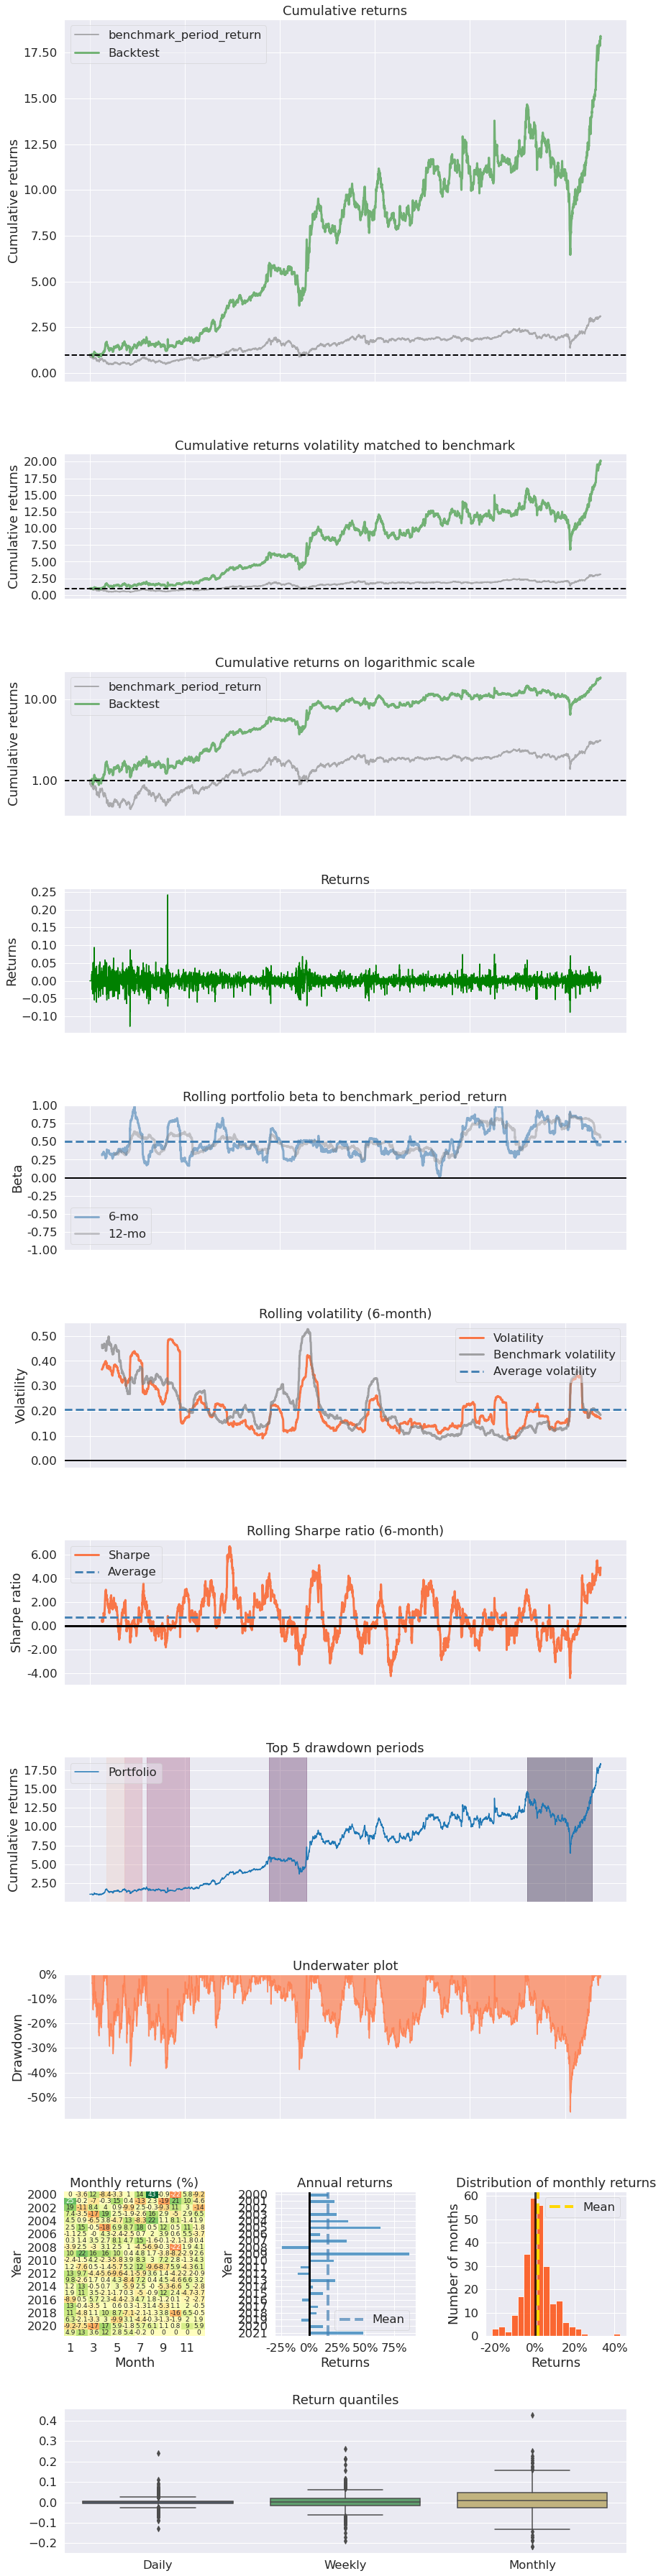

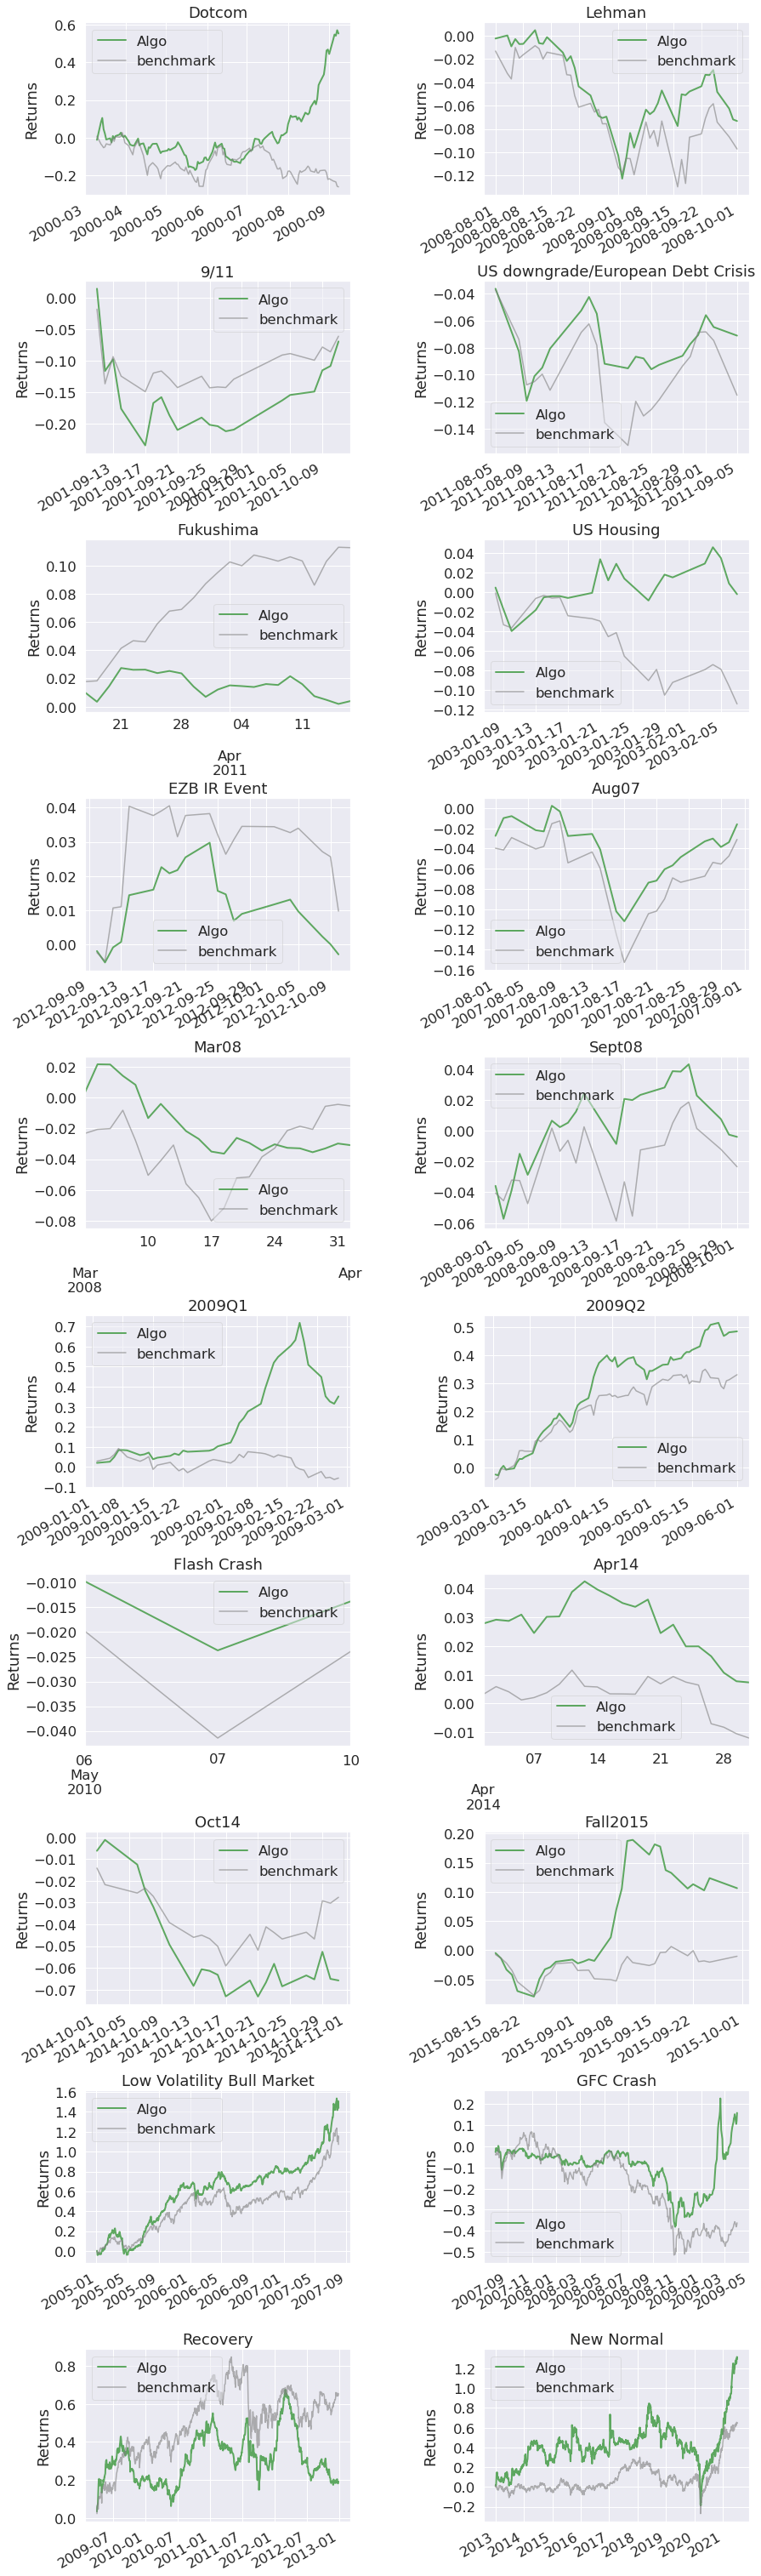

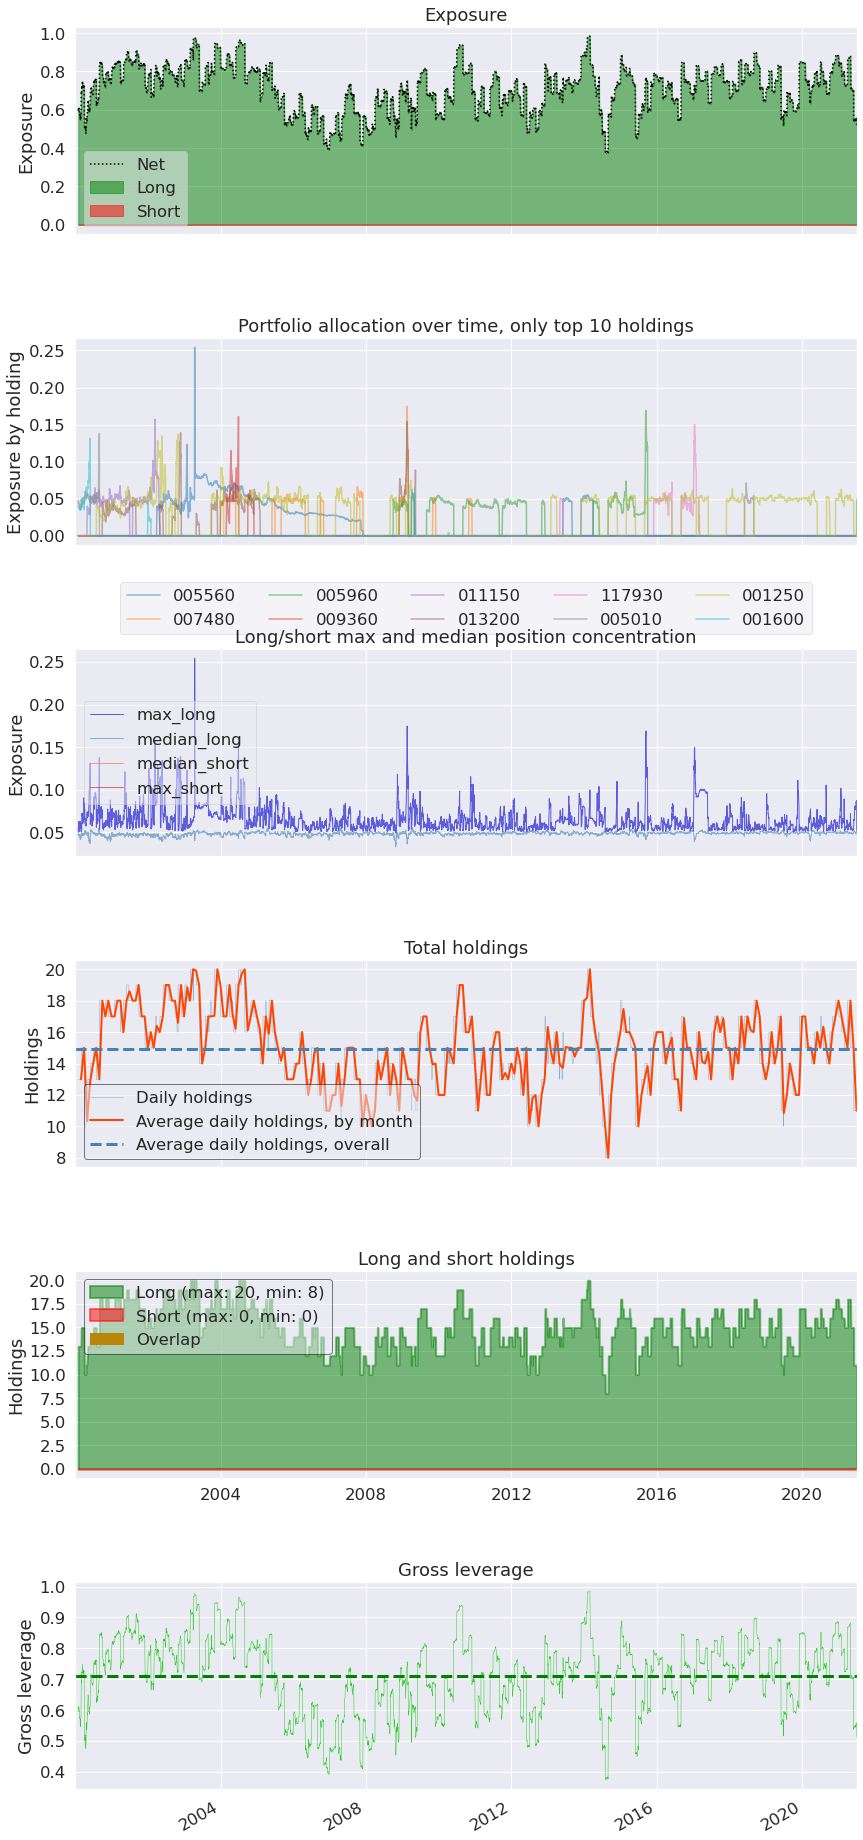

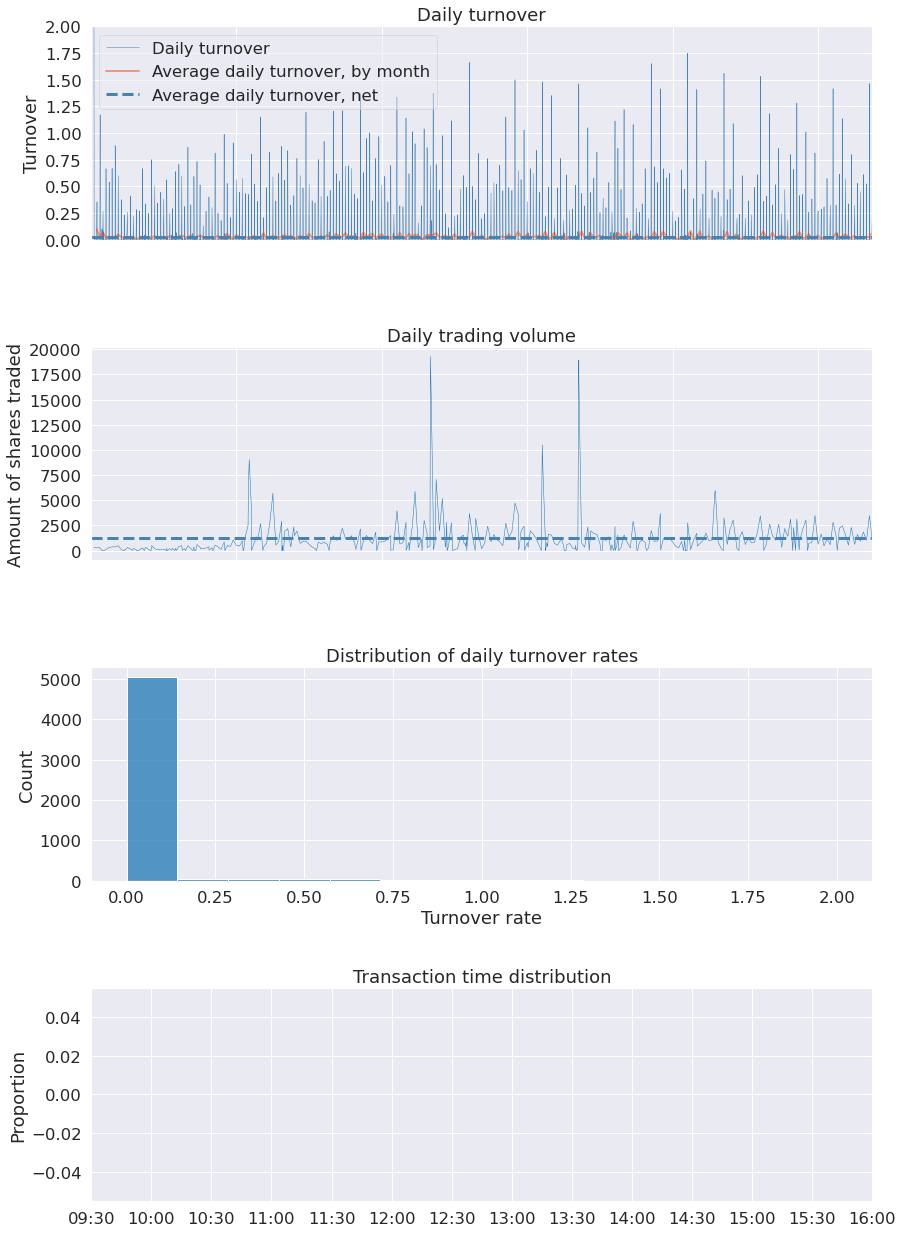

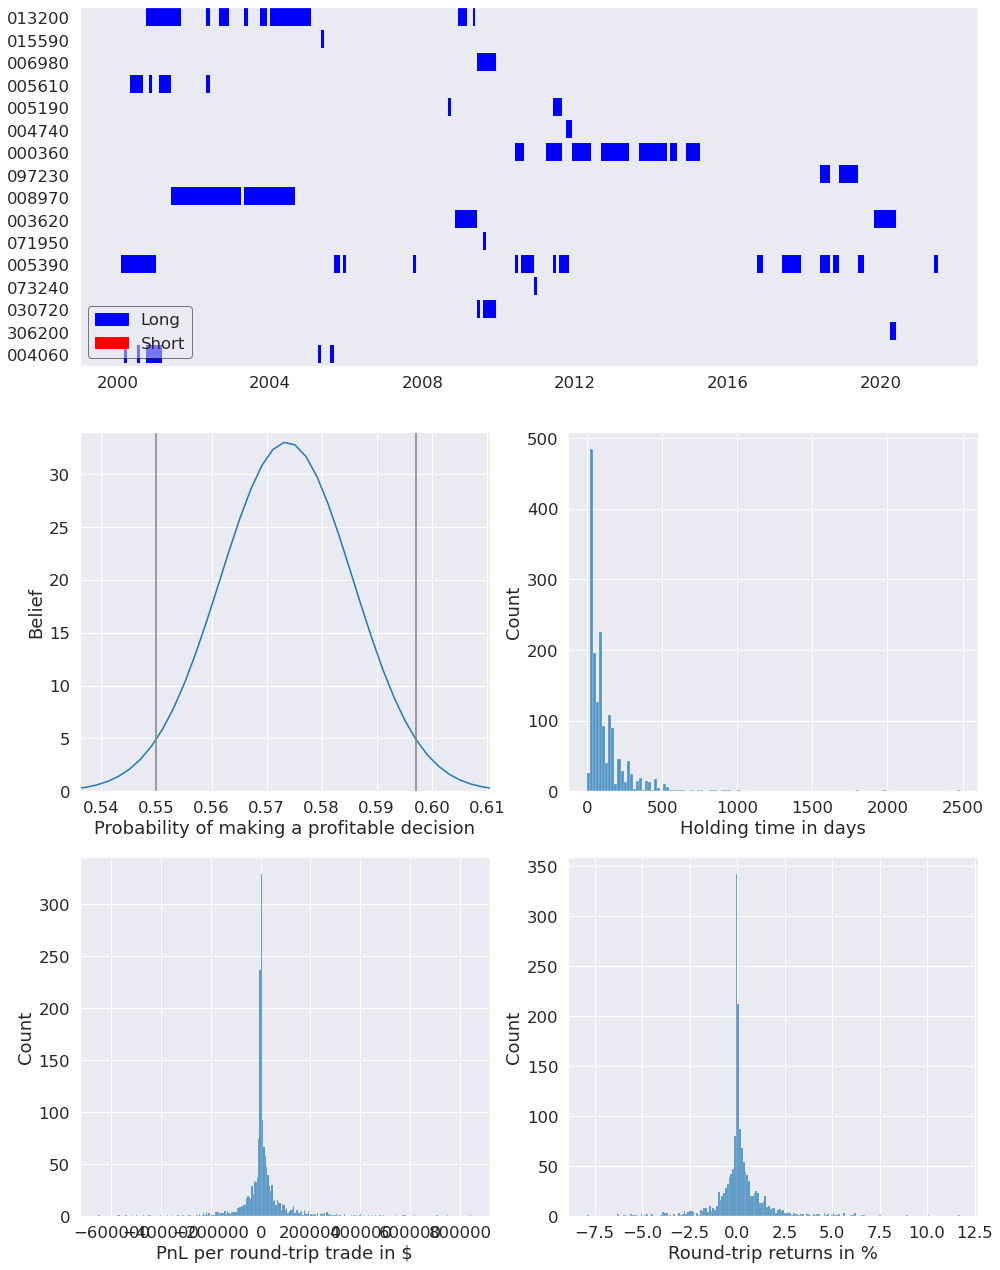

In [26]:
pf.create_full_tear_sheet(returns, 
                          positions=positions, 
                          transactions=transactions,
                          benchmark_rets=benchmark,
                          round_trips=True)